## FINAL FILE

In [7]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import tensorflow as tf
from  tensorflow.keras.preprocessing.sequence import pad_sequences
from  sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from tensorflow.keras import layers
from tensorflow.keras import Model
import nltk.translate.bleu_score as bleu
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df= pd.read_csv("/content/drive/MyDrive/ColabNotebooks/cs2/processed_data.csv")
df.columns = ["enc_input","dec_input","y"] 
df["dec_output"] = df.dec_input
df

,enc_input,dec_input,y,dec_output
0,and he took in my favorite subject like soccer,and he took in my favorite subjects like soccer,1,and he took in my favorite subjects like soccer
1,actually who let me know about lang 8 was him,actually he was the one who let me know about ...,1,actually he was the one who let me know about ...
2,his kanji is ability is much better than me,his kanji ability is much better than mine,1,his kanji ability is much better than mine
3,we have known each other for only half a year ...,we have known each other for only half a year ...,1,we have known each other for only half a year ...
4,i heard a sentence last night when i watched tv,i heard a sentence last night when i was watch...,1,i heard a sentence last night when i was watch...
...,...,...,...,...
505893,hmmm thk i usually book on wkends depends la,hmm i think i usually book on weekends it depends,2,hmm i think i usually book on weekends it depends
505894,ask them got any sms messages to gif me leinow...,can you ask them whether they have for any sms...,2,can you ask them whether they have for any sms...
505895,we r near coca oredi,we are near coca already,2,we are near coca already
505896,hall eleven got lectures le mahn forget abt co...,hall eleven got lectures and forget about comp...,2,hall eleven got lectures and forget about comp...


In [14]:
df_sampled = pd.concat((df[df.y==1].sample(frac= 0.2,random_state=1),df[df.y==2]))
## HERE I AM SAMPLING 1000 POINTS FROM THE DATAFRAME AS TEST DATA WHICH ARE NOT PRESEENT IN THE TRAIN AND VALIDAION DATA
np.random.seed(5) 
df_test = df.loc[np.random.choice(np.array([x for x in df.index.values if x not in df_sampled.index.values]),1000,replace= False,)]
df_test

,enc_input,dec_input,y,dec_output
144583,you are meeting your friends and going to a ba...,<start> you are meeting your friends and going...,1,you are meeting your friends and going to a ba...
455599,but since i got here i have not studied a lot,<start> but since i got here i have not studie...,1,but since i got here i have not studied very ...
13922,we had lunch with them in a house flooded by t...,<start> we had lunch with those whose house ha...,1,we had lunch with those whose house had been f...
128968,an professor introduced me to her,<start> a professor introduced me to her,1,a professor introduced me to her <end>
402800,his companions were having drinks in front of ...,<start> his companions were having drinks in f...,1,his companions were having drinks in front of ...
...,...,...,...,...
352632,so many people is suffuring from hunger povert...,<start> so many people are suffering from hung...,1,so many people are suffering from hunger and p...
191449,i wish i could be of some help during this big...,<start> i hope to offer some help in this big ...,1,i hope to offer some help in this big change b...
179722,anyway what i hope is he will come to shanghai...,<start> anyway what i hope is that he will com...,1,anyway what i hope is that he will come to sha...
38604,i just saw something on the facebook,<start> i just saw something on facebook,1,i just saw something on facebook <end>


### Note: The model that i am using in final file is Monotonic Attention model which computes score values by dot product

In [25]:
def function1(text):
    starttime1 = datetime.now()
    ## TEXT PREPROCESSING ########
    def remove_spaces(text):
        text = re.sub(r" '(\w)",r"'\1",text)
        text = re.sub(r" \,",",",text)
        text = re.sub(r" \.+",".",text)
        text = re.sub(r" \!+","!",text)
        text = re.sub(r" \?+","?",text)
        text = re.sub(" n't","n't",text)
        text = re.sub("[\(\)\;\_\^\`\/]","",text)
        
        return text

    def decontract(text):
        text = re.sub(r"won\'t", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        return text
    def preprocess(text):
        text = re.sub("\n","",text)
        text = remove_spaces(text)   # REMOVING UNWANTED SPACES
        text = re.sub(r"\.+",".",text)
        text = re.sub(r"\!+","!",text)
        text = decontract(text)    # DECONTRACTION
        text = re.sub("[^A-Za-z0-9 ]+","",text)
        text = text.lower()
        return text
    
    text = preprocess(text)


    # FORMING TOKENIZED SEQUENCES FOR INPUT SENTENCE
    tk_inp = pickle.load(open("/content/drive/MyDrive/ColabNotebooks/cs2/final/tk_inp","rb"))
    seq = tk_inp.texts_to_sequences([text])
    # PADDING THE SEQUENCES
    seq = pad_sequences(seq,maxlen = 20 , padding="post")
    tk_out = pickle.load(open("/content/drive/MyDrive/ColabNotebooks/cs2/final/tk_out","rb"))

    #### Model #########################
    class Encoder(tf.keras.layers.Layer):

        '''
        Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
        '''
        
        def __init__(self, vocab_size,emb_dims, enc_units, input_length,batch_size):
            super().__init__()
            self.vocab_size = vocab_size
            self.emb_dims = emb_dims
            self.input_length = input_length
            # INITIALIZING THE REQUIRED VARIABLES
            self.batch_size=batch_size # BATHCH SIZE
            self.enc_units = enc_units # ENCODER UNITS

            # EMBEDDING LAYER
            self.embedding= layers.Embedding(vocab_size ,emb_dims) 
            # LSTM LAYER WITH RETURN SEQ AND RETURN STATES
            self.lstm = layers.LSTM(self.enc_units,return_state= True,return_sequences =  True) 
            
        def call(self, enc_input , states):
            '''
            This function takes a sequence input and the initial states of the encoder.
            Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
            returns -- encoder_output, last time step's hidden and cell state
            '''
            # FORMING THE EMBEDDED VECTOR 
            emb = self.embedding(enc_input)
            # PASSING THE EMBEDDED VECTIO THROUGH LSTM LAYERS 
            enc_output,state_h,state_c = self.lstm(emb,initial_state=states)
            #RETURNING THE OUTPUT OF LSTM LAYER
            return enc_output,state_h,state_c 
        
        def initialize(self,batch_size):

            '''
            Given a batch size it will return intial hidden state and intial cell state.
            If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
            '''
            return tf.zeros(shape=(batch_size,self.enc_units)),tf.zeros(shape=(batch_size,self.enc_units))
        def get_config(self):
            config = super(Encoder, self).get_config()
            config.update({"vocab_size":self.vocab_size,"emb_dims":self.emb_dims, "enc_units":self.enc_units,"input_length":self.input_length,"batch_size":self.batch_size})
            return config

    class Monotonic_Attention(tf.keras.layers.Layer):
        '''THIS FUNCTION RETURNS THE CONTEXT VECTOR AND ATTENTION WEIGHTS (ALPHA VALUES)'''
        def __init__(self,units,att_mode):
            super().__init__()
            self.units = units
            self.att_mode = att_mode
            # INITIALIZING THE DENSE LAYER W1
            self.W1 = layers.Dense(units)
            # INITIALIZING THE DENSE LAYER W2
            self.W2 = layers.Dense(units)
            # INITIALIZING THE DENSE LAYER V
            self.v = layers.Dense(1)
            self.mode = att_mode
            
        def call(self,enc_output,dec_state,prev_att):
            # HERE WE ARE COMPUTING THE SCORE 

            if self.mode == "dot":
            # FINDING THE SCORE FOR DOT MODEL
                dec_state =  tf.expand_dims(dec_state,axis=-1)
                score = tf.matmul(enc_output,dec_state)
                score = tf.squeeze(score, [2])
                
                
            if self.mode == "general":
            # FINDING THE SCORE FOR GENERAL MODEL
                dec_state =  tf.expand_dims(dec_state,axis=-1)
                dense_output = self.W1(enc_output)
                score = tf.matmul(dense_output , dec_state)
                score = tf.squeeze(score, [2])
                
                
            if self.mode == "concat":
            # FINDING THE SCORE FOR CONCAT MODEL
                dec_state =  tf.expand_dims(dec_state,axis=1)
                score = self.v(tf.nn.tanh(
                    self.W1(dec_state)+ self.W2(enc_output)))
                score = tf.squeeze(score, [2])
            
            # AFTER THE SOCRES ARE COMPUTED THE SIGMOID IS USED ON IT
            probabilities = tf.sigmoid(score)

            # ATTENTION WEIGHTS FOR PRESENT TIME STEP
            probabilities = probabilities*tf.cumsum(tf.squeeze(prev_att,-1), axis=1)
            attention = probabilities*tf.math.cumprod(1-probabilities, axis=1, exclusive=True)
            attention = tf.expand_dims(attention,axis=-1)
            
            # CONTEXT VECTOR
            context_vec  =  attention  * enc_output
            context_vec = tf.reduce_sum(context_vec,axis=1)
            
            # RETURN CONTEXT VECTOR AND ATTENTION
            return context_vec, attention
        def get_config(self):
            config = super(Monotonic_Attention, self).get_config()
            config.update({"units":self.units,"att_mode":self.att_mode})
            return config

    class Onestepdecoder(tf.keras.Model):
        '''THIS MODEL OUTPUTS THE RESULT OF DECODER FOR ONE TIME SETP GIVEN THE INPUT FOR PRECIOVE TIME STEP'''
    
        def __init__(self, vocab_size,emb_dims, dec_units, input_len,att_units,batch_size, att_mode):
            super().__init__()
            self.vocab_size = vocab_size
            self.emb_dims = emb_dims
            self.dec_units = dec_units
            self.input_len = input_len
            self.att_units = att_units
            self.batch_size = batch_size
            self.att_mode = att_mode

            # INTITALIZING THE REQUIRED VARIABLES
            # EMBEDDING LAYERS
            self.emb = layers.Embedding(vocab_size,emb_dims,input_length= input_len)
            # ATTENTION LAYER
            self.att = Monotonic_Attention(att_units,att_mode)
            # LSTM LAYER
            self.lstm = layers.LSTM(dec_units,return_sequences=True,return_state=True)
            # DENSE LAYER
            self.dense = layers.Dense(vocab_size,activation="softmax")

        def call(self, encoder_output , input , state_h,state_c,previous_attention):
            # FORMING THE EMBEDDED VECTOR FOR THE WORD
            # (32,1)=>(32,1,12)
            emb = self.emb(input)

            dec_output,dec_state_h,dec_state_c = self.lstm(emb, initial_state = [state_h,state_c] )

            # GETTING THE CONTEXT VECTOR AND ATTENTION WEIGHTS BASED ON THE ENCODER OUTPUT AND  DECODER STATE_H
            context_vec,alphas = self.att(encoder_output,dec_state_h,previous_attention)
            
            # CONCATINATING THE CONTEXT VECTOR(BY EXPANDING DIMENSION) AND ENBEDDED VECTOR
            dense_input =  tf.concat([tf.expand_dims(context_vec,1),dec_output],axis=-1)
            
            # PASSING THE DECODER OUTPUT THROUGH DENSE LAYER WITH UNITS EQUAL TO VOCAB SIZE
            fc = self.dense(dense_input)
            
            # RETURNING THE OUTPUT
            return fc , dec_state_h , dec_state_c , alphas


        def get_config(self):
            config=({ "vocab_size":self.vocab_size,"emb_dims":self.emb_dims,"dec_units": self.dec_units,"input_len": self.input_len,"att_units":self.att_units,"batch_size":self.batch_size, "att_mode":self.att_mode})
            return config

        @classmethod
        def from_config(cls, config):
            return cls(**config)

    class Decoder(tf.keras.Model):
        '''THIS MODEL PERFORMS THE WHOLE DECODER OPERATION FOR THE COMPLETE SENTENCE'''
        def __init__(self, vocab_size,emb_dims, dec_units, input_len,att_units,batch_size,att_mode):
            super().__init__()
            self.vocab_size = vocab_size
            self.emb_dims = emb_dims
            self.dec_units = dec_units
            
            self.att_units = att_units
            self.batch_size = batch_size
            self.att_mode = att_mode

            # INITIALIZING THE VARIABLES
            # LENGTH OF INPUT SENTENCE
            self.input_len = input_len
            # ONE STEP DECODER
            self.onestepdecoder = Onestepdecoder(vocab_size,emb_dims, dec_units, input_len,att_units,batch_size,att_mode)

        def call(self,dec_input,enc_output,state_h,state_c,initial_attention):
            # THIS VATIABLE STORES THE VALUE OF STATE_H FOR THE PREVIOUS STATE
            current_state_h = state_h 
            current_state_c = state_c
            previous_attention = initial_attention
            # THIS STORES THE DECODER OUTPUT FOR EACH TIME STEP
            pred = []
            # THIS STORED THE ALPHA VALUES
            alpha_values = []
            # FOR EACH WORD IN THE INPUT SENTENCE
            for i in range(self.input_len):
                
                # CURRENT WORD TO INPUT TO ONE STEP DECODER
                current_vec = dec_input[:,i]

                # EXPANDING THE DIMENSION FOR THE WORD
                current_vec = tf.expand_dims(current_vec,axis=-1)

                # PERFORMING THE ONE STEP DECODER OPERATION 
                dec_output,dec_state_h,dec_state_c,alphas = self.onestepdecoder(enc_output ,current_vec,current_state_h,current_state_c,previous_attention)

                #UPDATING THE CURRENT STATE_H
                current_state_h = dec_state_h
                current_state_c = dec_state_c
                previous_attention = alphas
                
                #APPENDING THE DECODER OUTPUT TO "pred" LIST
                pred.append(dec_output)

                # APPENDING THE ALPHA VALUES
                alpha_values.append(alphas)
                
            # CONCATINATING ALL THE VALUES IN THE LIST
            output = tf.concat(pred,axis=1)
            # CONCATINATING ALL THE ALPHA VALUES IN THE LIST
            alpha_values = tf.concat(alpha_values,axis = -1)
            # RETURNING THE OUTPUT
            return output , alpha_values
        def get_config(self):
          config = ({ "vocab_size":self.vocab_size,"emb_dims":self.emb_dims,"dec_units": self.dec_units, "input_len":self.input_len,"att_units":self.att_units,"batch_size":self.batch_size,"att_model":self.att_mode})
          return config

        @classmethod
        def from_config(cls, config):
            return cls(**config)
    class encoder_decoder(tf.keras.Model):
        '''THIS MODEL COMBINES ALL THE LAYERS AND FORM IN ENCODER DECODER MODEL WITH ATTENTION MECHANISM'''
        def __init__(self,enc_vocab_size,enc_emb_dim,enc_units,enc_input_length,
                dec_vocab_size,dec_emb_dim,dec_units,dec_input_length ,att_units, batch_size,att_mode):
            # INITAILIZING ALL VARIABLES
            super().__init__()
            self.enc_vocab_size= enc_vocab_size
            self.enc_emb_dim=enc_emb_dim
            self.enc_units= enc_units
            self.enc_input_length =enc_input_length
            self.dec_vocab_size=dec_vocab_size
            self.dec_emb_dim=dec_emb_dim
            self.dec_units=dec_units
            self.dec_input_length =dec_input_length
            self.att_units=att_units
            self.att_mode=att_mode

            # BATCH SIZE
            self.batch_size = batch_size
            # INITIALIZING ENCODER LAYER
            self.encoder = Encoder(enc_vocab_size, enc_emb_dim,enc_units, enc_input_length,batch_size)
            # INITALIZING DECODER LAYER
            self.decoder = Decoder(dec_vocab_size ,dec_emb_dim,dec_units,dec_input_length  ,att_units, batch_size,att_mode)
            self.input_len = enc_input_length
            
            
        def call(self,data):
            # THE INPUT OF DATALOADER IS IN A LIST FORM FOR EACH BATCH IT GIVER TWO INPUTS
            # INPUT1 IS FOR ENCODER
            # INPUT2 IS FOR DECODER
            inp1 , inp2 = data
            # PASSING THE INPUT1 TO ENCODER LAYER
            enc_output, enc_state_h, enc_state_c = self.encoder(inp1,self.encoder.initialize(self.batch_size))
            # PASSING INPUT2 TO THE DECODER LAYER
            initial_attention = np.zeros(shape = (self.batch_size,self.input_len,1),dtype="float32")
            initial_attention[:,1] = 1 
            dec_output , alphas = self.decoder(inp2 , enc_output,enc_state_h,enc_state_c ,initial_attention)
            # THE OUTPUT OF MODEL IS ONLY DECODER OUTPUT THE ALPHA VALUES ARE IGNORED HERE
            return dec_output

        def get_config(self):
            config = ({"enc_vocab_size":self.enc_vocab_size, 
                      "enc_emb_dim":self.enc_emb_dim,"enc_units":self.enc_units,"enc_input_length":self.enc_input_length,\
                "dec_vocab_size":self.dec_vocab_size,
                "dec_emb_dim":self.dec_emb_dim,
                "dec_units":self.dec_units,
                "dec_input_length":self.dec_input_length ,\
                "att_units":self.att_units, "batch_size":self.batch_size,"att_mode":self.att_mode})
            return config
        @classmethod
        def from_config(cls, config):
            return cls(**config)

    # INITAILZING THE MODEL
    model = encoder_decoder(enc_vocab_size=len(tk_inp.word_index)+1,
                            enc_emb_dim = 300,
                            enc_units=256,enc_input_length=35,
                            dec_vocab_size =len(tk_out.word_index)+1,
                            dec_emb_dim =300,
                            dec_units=256,
                            dec_input_length = 35,
                            
                            att_units=256,
                            batch_size=512,
                              att_mode = "dot")
    model.compile(optimizer="adam",loss='sparse_categorical_crossentropy')
    model.build([(512,35),(512,35)])
    
    model.load_weights("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/monitonic_attention_dot/best.h5")

    print("####### Model Loaded ###########")
    time2 = datetime.now()
    print("Loading time = ", (time2-starttime1).total_seconds(),"seconds")

    # INITIALIZING THE STATES FOR INPUTING TO ENCODER
    state = model.layers[0].initialize(1)

    # GETTING THE ENCODED OUTPUT
    enc_output,state_h,state_c= model.layers[0](seq,state)
    # VARIABLE TO STORE PREDICTED SENTENCE
    pred = []
    # THIS VARIABLE STORES THE STATE TO BE INPUTED TO ONE STEP ENCODER
    input_state_h = state_h
    input_state_c = state_c
    prev_attention = np.zeros(shape = (1,20,1),dtype="float32")
    prev_attention[:,1] = 1 
    # THIS VARIABLE STORES THE VECTOR TO VE INPUTED TO ONE STEP ENCODER
    current_vec = tf.ones((1,1))
    # THIS VARIABLE WILL STORE ALL THE ALPHA VALUES OUTPUTS
    alpha_values = []

    for i in range(20):
        # PASSING THE REQUIRED VARIABLE TO ONE STEP ENCODER LAYER
        fc , dec_state_h ,dec_state_c, alphas = model.layers[1].layers[0](enc_output , current_vec ,input_state_h ,input_state_c,prev_attention)
        #APPENDING THE ALPHA VALUES TO THE LIST "alpha_values"
        alpha_values.append(alphas)
         # UPDATING THE CURRENT VECTOR 
        current_vec = np.argmax(fc , axis = -1)
         # UPDATING THE INPUT STATE
        input_state_h = dec_state_h
        input_state_c = dec_state_c
        prev_attention = alphas
        # GETTING THE ACTUAL WORDS FRO THE TOKENIZED INDEXES
        pred.append(tk_out.index_word[current_vec[0][0]])
        # IF THE WORD "<end>" COMES THE LOOP WILL BREAK
        if tk_out.index_word[current_vec[0][0]]=="<end>":
              break
    # JOINING THE PREDICTED WORDS
    pred_sent = " ".join(pred)
    # CONCATINATING ALL THE ALPHA VALUES
    alpha_values = tf.squeeze(tf.concat(alpha_values,axis=-1),axis=0)
    # RETURNING THE PREDICTED SENTENCE AND ALPHA VALUES
    print("Predicted Output",pred_sent)
    print("="*50)
    #### Plot for alphas #####
    def plot( input_sent , output_sent , alpha ) :
        '''THIS FUNCTION PLOTS THE ALPHA VALUES IN FORM OF HEAT MAPS'''
      
        input_words = input_sent.split() # SPLITTING THE INPUT SENTENCE
        output_words = output_sent.split() # SPLITTING THE OUTPUT SENTENCE
        
        fig, ax = plt.subplots()
        sns.set_style("darkgrid")
        # HEAT MAP WITH ALPHA VALURS 
        # X LABELS ARE THE OUTPUT WORDS 
        # T LABELS ARE THE INPUT WORDS
        sns.heatmap(alpha[:len(input_words),:], xticklabels= output_words , yticklabels=input_words,linewidths=0.01)
        # PLACING THE TICKS ON  THE TOP
        ax.xaxis.tick_top( ) 
        plt.show()

    plot(text,pred_sent,alpha_values)
    print("="*50)
    print("Prediction time = ", (datetime.now()-time2).total_seconds(),"seconds")


####### Model Loaded ###########
Loading time =  8.008193 seconds
Predicted Output i found that some of my friends had been here <end>


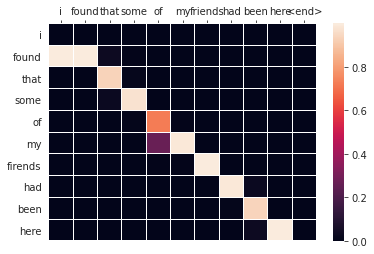

Prediction time =  0.378023 seconds


In [26]:
function1(df_test.enc_input.values[50])

####### Model Loaded ###########
Loading time =  8.395404 seconds
Predicted Output but he understood the meanings <end>


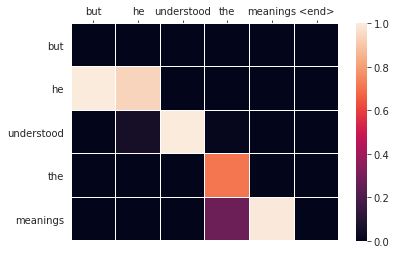

Prediction time =  0.299987 seconds


In [19]:
function1(df_test.enc_input.values[500])

#### Observation: We can clearly see that the loading of the model is takin majority of time. Once the model is loaded the predictios takes less than 1 second to occur.

In [34]:
def function2(text,actual_output):

    ## TEXT PREPROCESSING ### 
    def remove_spaces(text):
        text = re.sub(r" '(\w)",r"'\1",text)
        text = re.sub(r" \,",",",text)
        text = re.sub(r" \.+",".",text)
        text = re.sub(r" \!+","!",text)
        text = re.sub(r" \?+","?",text)
        text = re.sub(" n't","n't",text)
        text = re.sub("[\(\)\;\_\^\`\/]","",text)
        
        return text

    def decontract(text):
        text = re.sub(r"won\'t", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        return text
    def preprocess(text):
        text = re.sub("\n","",text)
        text = remove_spaces(text)   # REMOVING UNWANTED SPACES
        text = re.sub(r"\.+",".",text)
        text = re.sub(r"\!+","!",text)
        text = decontract(text)    # DECONTRACTION
        text = re.sub("[^A-Za-z0-9 ]+","",text)
        text = text.lower()
        return text
    
    text = preprocess(text)
    


    # FORMING TOKENIZED SEQUENCES FOR INPUT SENTENCE
    tk_inp = pickle.load(open("/content/drive/MyDrive/ColabNotebooks/cs2/final/tk_inp","rb"))
    seq = tk_inp.texts_to_sequences([text])
    # PADDING THE SEQUENCES
    seq = pad_sequences(seq,maxlen = 20 , padding="post")
    tk_out = pickle.load(open("/content/drive/MyDrive/ColabNotebooks/cs2/final/tk_out","rb"))

    #### Model #########################
    class Encoder(tf.keras.layers.Layer):

        '''
        Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
        '''
        
        def __init__(self, vocab_size,emb_dims, enc_units, input_length,batch_size):
            super().__init__()
            self.vocab_size = vocab_size
            self.emb_dims = emb_dims
            self.input_length = input_length
            # INITIALIZING THE REQUIRED VARIABLES
            self.batch_size=batch_size # BATHCH SIZE
            self.enc_units = enc_units # ENCODER UNITS

            # EMBEDDING LAYER
            self.embedding= layers.Embedding(vocab_size ,emb_dims) 
            # LSTM LAYER WITH RETURN SEQ AND RETURN STATES
            self.lstm = layers.LSTM(self.enc_units,return_state= True,return_sequences =  True) 
            
        def call(self, enc_input , states):
            '''
            This function takes a sequence input and the initial states of the encoder.
            Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
            returns -- encoder_output, last time step's hidden and cell state
            '''
            # FORMING THE EMBEDDED VECTOR 
            emb = self.embedding(enc_input)
            # PASSING THE EMBEDDED VECTIO THROUGH LSTM LAYERS 
            enc_output,state_h,state_c = self.lstm(emb,initial_state=states)
            #RETURNING THE OUTPUT OF LSTM LAYER
            return enc_output,state_h,state_c 
        
        def initialize(self,batch_size):

            '''
            Given a batch size it will return intial hidden state and intial cell state.
            If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
            '''
            return tf.zeros(shape=(batch_size,self.enc_units)),tf.zeros(shape=(batch_size,self.enc_units))
        def get_config(self):
            config = super(Encoder, self).get_config()
            config.update({"vocab_size":self.vocab_size,"emb_dims":self.emb_dims, "enc_units":self.enc_units,"input_length":self.input_length,"batch_size":self.batch_size})
            return config

    class Monotonic_Attention(tf.keras.layers.Layer):
        '''THIS FUNCTION RETURNS THE CONTEXT VECTOR AND ATTENTION WEIGHTS (ALPHA VALUES)'''
        def __init__(self,units,att_mode):
            super().__init__()
            self.units = units
            self.att_mode = att_mode
            # INITIALIZING THE DENSE LAYER W1
            self.W1 = layers.Dense(units)
            # INITIALIZING THE DENSE LAYER W2
            self.W2 = layers.Dense(units)
            # INITIALIZING THE DENSE LAYER V
            self.v = layers.Dense(1)
            self.mode = att_mode
            
        def call(self,enc_output,dec_state,prev_att):
            # HERE WE ARE COMPUTING THE SCORE 

            if self.mode == "dot":
            # FINDING THE SCORE FOR DOT MODEL
                dec_state =  tf.expand_dims(dec_state,axis=-1)
                score = tf.matmul(enc_output,dec_state)
                score = tf.squeeze(score, [2])
                
                
            if self.mode == "general":
            # FINDING THE SCORE FOR GENERAL MODEL
                dec_state =  tf.expand_dims(dec_state,axis=-1)
                dense_output = self.W1(enc_output)
                score = tf.matmul(dense_output , dec_state)
                score = tf.squeeze(score, [2])
                
                
            if self.mode == "concat":
            # FINDING THE SCORE FOR CONCAT MODEL
                dec_state =  tf.expand_dims(dec_state,axis=1)
                score = self.v(tf.nn.tanh(
                    self.W1(dec_state)+ self.W2(enc_output)))
                score = tf.squeeze(score, [2])
            
            # AFTER THE SOCRES ARE COMPUTED THE SIGMOID IS USED ON IT
            probabilities = tf.sigmoid(score)

            # ATTENTION WEIGHTS FOR PRESENT TIME STEP
            probabilities = probabilities*tf.cumsum(tf.squeeze(prev_att,-1), axis=1)
            attention = probabilities*tf.math.cumprod(1-probabilities, axis=1, exclusive=True)
            attention = tf.expand_dims(attention,axis=-1)
            
            # CONTEXT VECTOR
            context_vec  =  attention  * enc_output
            context_vec = tf.reduce_sum(context_vec,axis=1)
            
            # RETURN CONTEXT VECTOR AND ATTENTION
            return context_vec, attention
        def get_config(self):
            config = super(Monotonic_Attention, self).get_config()
            config.update({"units":self.units,"att_mode":self.att_mode})
            return config

    class Onestepdecoder(tf.keras.Model):
        '''THIS MODEL OUTPUTS THE RESULT OF DECODER FOR ONE TIME SETP GIVEN THE INPUT FOR PRECIOVE TIME STEP'''
    
        def __init__(self, vocab_size,emb_dims, dec_units, input_len,att_units,batch_size, att_mode):
            super().__init__()
            self.vocab_size = vocab_size
            self.emb_dims = emb_dims
            self.dec_units = dec_units
            self.input_len = input_len
            self.att_units = att_units
            self.batch_size = batch_size
            self.att_mode = att_mode

            # INTITALIZING THE REQUIRED VARIABLES
            # EMBEDDING LAYERS
            self.emb = layers.Embedding(vocab_size,emb_dims,input_length= input_len)
            # ATTENTION LAYER
            self.att = Monotonic_Attention(att_units,att_mode)
            # LSTM LAYER
            self.lstm = layers.LSTM(dec_units,return_sequences=True,return_state=True)
            # DENSE LAYER
            self.dense = layers.Dense(vocab_size,activation="softmax")

        def call(self, encoder_output , input , state_h,state_c,previous_attention):
            # FORMING THE EMBEDDED VECTOR FOR THE WORD
            # (32,1)=>(32,1,12)
            emb = self.emb(input)

            dec_output,dec_state_h,dec_state_c = self.lstm(emb, initial_state = [state_h,state_c] )

            # GETTING THE CONTEXT VECTOR AND ATTENTION WEIGHTS BASED ON THE ENCODER OUTPUT AND  DECODER STATE_H
            context_vec,alphas = self.att(encoder_output,dec_state_h,previous_attention)
            
            # CONCATINATING THE CONTEXT VECTOR(BY EXPANDING DIMENSION) AND ENBEDDED VECTOR
            dense_input =  tf.concat([tf.expand_dims(context_vec,1),dec_output],axis=-1)
            
            # PASSING THE DECODER OUTPUT THROUGH DENSE LAYER WITH UNITS EQUAL TO VOCAB SIZE
            fc = self.dense(dense_input)
            
            # RETURNING THE OUTPUT
            return fc , dec_state_h , dec_state_c , alphas


        def get_config(self):
            config=({ "vocab_size":self.vocab_size,"emb_dims":self.emb_dims,"dec_units": self.dec_units,"input_len": self.input_len,"att_units":self.att_units,"batch_size":self.batch_size, "att_mode":self.att_mode})
            return config

        @classmethod
        def from_config(cls, config):
            return cls(**config)

    class Decoder(tf.keras.Model):
        '''THIS MODEL PERFORMS THE WHOLE DECODER OPERATION FOR THE COMPLETE SENTENCE'''
        def __init__(self, vocab_size,emb_dims, dec_units, input_len,att_units,batch_size,att_mode):
            super().__init__()
            self.vocab_size = vocab_size
            self.emb_dims = emb_dims
            self.dec_units = dec_units
            
            self.att_units = att_units
            self.batch_size = batch_size
            self.att_mode = att_mode

            # INITIALIZING THE VARIABLES
            # LENGTH OF INPUT SENTENCE
            self.input_len = input_len
            # ONE STEP DECODER
            self.onestepdecoder = Onestepdecoder(vocab_size,emb_dims, dec_units, input_len,att_units,batch_size,att_mode)

        def call(self,dec_input,enc_output,state_h,state_c,initial_attention):
            # THIS VATIABLE STORES THE VALUE OF STATE_H FOR THE PREVIOUS STATE
            current_state_h = state_h 
            current_state_c = state_c
            previous_attention = initial_attention
            # THIS STORES THE DECODER OUTPUT FOR EACH TIME STEP
            pred = []
            # THIS STORED THE ALPHA VALUES
            alpha_values = []
            # FOR EACH WORD IN THE INPUT SENTENCE
            for i in range(self.input_len):
                
                # CURRENT WORD TO INPUT TO ONE STEP DECODER
                current_vec = dec_input[:,i]

                # EXPANDING THE DIMENSION FOR THE WORD
                current_vec = tf.expand_dims(current_vec,axis=-1)

                # PERFORMING THE ONE STEP DECODER OPERATION 
                dec_output,dec_state_h,dec_state_c,alphas = self.onestepdecoder(enc_output ,current_vec,current_state_h,current_state_c,previous_attention)

                #UPDATING THE CURRENT STATE_H
                current_state_h = dec_state_h
                current_state_c = dec_state_c
                previous_attention = alphas
                
                #APPENDING THE DECODER OUTPUT TO "pred" LIST
                pred.append(dec_output)

                # APPENDING THE ALPHA VALUES
                alpha_values.append(alphas)
                
            # CONCATINATING ALL THE VALUES IN THE LIST
            output = tf.concat(pred,axis=1)
            # CONCATINATING ALL THE ALPHA VALUES IN THE LIST
            alpha_values = tf.concat(alpha_values,axis = -1)
            # RETURNING THE OUTPUT
            return output , alpha_values
        def get_config(self):
          config = ({ "vocab_size":self.vocab_size,"emb_dims":self.emb_dims,"dec_units": self.dec_units, "input_len":self.input_len,"att_units":self.att_units,"batch_size":self.batch_size,"att_model":self.att_mode})
          return config

        @classmethod
        def from_config(cls, config):
            return cls(**config)
    class encoder_decoder(tf.keras.Model):
        '''THIS MODEL COMBINES ALL THE LAYERS AND FORM IN ENCODER DECODER MODEL WITH ATTENTION MECHANISM'''
        def __init__(self,enc_vocab_size,enc_emb_dim,enc_units,enc_input_length,
                dec_vocab_size,dec_emb_dim,dec_units,dec_input_length ,att_units, batch_size,att_mode):
            # INITAILIZING ALL VARIABLES
            super().__init__()
            self.enc_vocab_size= enc_vocab_size
            self.enc_emb_dim=enc_emb_dim
            self.enc_units= enc_units
            self.enc_input_length =enc_input_length
            self.dec_vocab_size=dec_vocab_size
            self.dec_emb_dim=dec_emb_dim
            self.dec_units=dec_units
            self.dec_input_length =dec_input_length
            self.att_units=att_units
            self.att_mode=att_mode

            # BATCH SIZE
            self.batch_size = batch_size
            # INITIALIZING ENCODER LAYER
            self.encoder = Encoder(enc_vocab_size, enc_emb_dim,enc_units, enc_input_length,batch_size)
            # INITALIZING DECODER LAYER
            self.decoder = Decoder(dec_vocab_size ,dec_emb_dim,dec_units,dec_input_length  ,att_units, batch_size,att_mode)
            self.input_len = enc_input_length
            
            
        def call(self,data):
            # THE INPUT OF DATALOADER IS IN A LIST FORM FOR EACH BATCH IT GIVER TWO INPUTS
            # INPUT1 IS FOR ENCODER
            # INPUT2 IS FOR DECODER
            inp1 , inp2 = data
            # PASSING THE INPUT1 TO ENCODER LAYER
            enc_output, enc_state_h, enc_state_c = self.encoder(inp1,self.encoder.initialize(self.batch_size))
            # PASSING INPUT2 TO THE DECODER LAYER
            initial_attention = np.zeros(shape = (self.batch_size,self.input_len,1),dtype="float32")
            initial_attention[:,1] = 1 
            dec_output , alphas = self.decoder(inp2 , enc_output,enc_state_h,enc_state_c ,initial_attention)
            # THE OUTPUT OF MODEL IS ONLY DECODER OUTPUT THE ALPHA VALUES ARE IGNORED HERE
            return dec_output

        def get_config(self):
            config = ({"enc_vocab_size":self.enc_vocab_size, 
                      "enc_emb_dim":self.enc_emb_dim,"enc_units":self.enc_units,"enc_input_length":self.enc_input_length,\
                "dec_vocab_size":self.dec_vocab_size,
                "dec_emb_dim":self.dec_emb_dim,
                "dec_units":self.dec_units,
                "dec_input_length":self.dec_input_length ,\
                "att_units":self.att_units, "batch_size":self.batch_size,"att_mode":self.att_mode})
            return config
        @classmethod
        def from_config(cls, config):
            return cls(**config)

    # INITAILZING THE MODEL
    model = encoder_decoder(enc_vocab_size=len(tk_inp.word_index)+1,
                            enc_emb_dim = 300,
                            enc_units=256,enc_input_length=35,
                            dec_vocab_size =len(tk_out.word_index)+1,
                            dec_emb_dim =300,
                            dec_units=256,
                            dec_input_length = 35,
                            
                            att_units=256,
                            batch_size=512,
                              att_mode = "dot")
    model.compile(optimizer="adam",loss='sparse_categorical_crossentropy')
    model.build([(512,35),(512,35)])
    
    model.load_weights("/content/drive/MyDrive/ColabNotebooks/cs2/model_save/monitonic_attention_dot/best.h5")


    # INITIALIZING THE STATES FOR INPUTING TO ENCODER
    state = model.layers[0].initialize(1)

    # GETTING THE ENCODED OUTPUT
    enc_output,state_h,state_c= model.layers[0](seq,state)
    # VARIABLE TO STORE PREDICTED SENTENCE
    pred = []
    # THIS VARIABLE STORES THE STATE TO BE INPUTED TO ONE STEP ENCODER
    input_state_h = state_h
    input_state_c = state_c
    prev_attention = np.zeros(shape = (1,20,1),dtype="float32")
    prev_attention[:,1] = 1 
    # THIS VARIABLE STORES THE VECTOR TO VE INPUTED TO ONE STEP ENCODER
    current_vec = tf.ones((1,1))
    
    

    for i in range(20):
        # PASSING THE REQUIRED VARIABLE TO ONE STEP ENCODER LAYER
        fc , dec_state_h ,dec_state_c, alphas = model.layers[1].layers[0](enc_output , current_vec ,input_state_h ,input_state_c,prev_attention)
        #APPENDING THE ALPHA VALUES TO THE LIST "alpha_values"
        
         # UPDATING THE CURRENT VECTOR 
        current_vec = np.argmax(fc , axis = -1)
         # UPDATING THE INPUT STATE
        input_state_h = dec_state_h
        input_state_c = dec_state_c
        prev_attention = alphas
        # GETTING THE ACTUAL WORDS FRO THE TOKENIZED INDEXES
        pred.append(tk_out.index_word[current_vec[0][0]])
        # IF THE WORD "<end>" COMES THE LOOP WILL BREAK
        if tk_out.index_word[current_vec[0][0]]=="<end>":
              break
    # JOINING THE PREDICTED WORDS
    pred_sent = " ".join(pred)
    # CONCATINATING ALL THE ALPHA VALUES

    print("BLEU Score",bleu.sentence_bleu([actual_output.split()],pred_sent.split()))
    


## Function 2 for some random test datapoints

In [35]:
function2(df_test.enc_input.values[5],df_test.dec_output.values[5])

BLEU Score 0.587728372510532


In [36]:
function2(df_test.enc_input.values[50],df_test.dec_output.values[50])

BLEU Score 1.0


In [24]:
function2(df_test.enc_input.values[99],df_test.dec_output.values[99])

BLEU Score 0.5193071778680676
